In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import os
from zipfile import ZipFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [9]:
# Descomprimir el conjunto de datos de "Stop"
with ZipFile('/content/stop.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/Stop')

# Descomprimir el conjunto de datos de "No Stop"
with ZipFile('/content/not_stop.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data/NoStop')


In [10]:
import shutil
import random

# Crear directorios para entrenamiento y validación
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

classes = ['Stop', 'NoStop']

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    src_dir = os.path.join(base_dir, cls)
    all_files = os.listdir(src_dir)
    random.shuffle(all_files)

    split_idx = int(len(all_files) * 0.8)
    train_files = all_files[:split_idx]
    val_files = all_files[split_idx:]

    for fname in train_files:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(train_dir, cls, fname)
        shutil.move(src, dst)

    for fname in val_files:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(val_dir, cls, fname)
        shutil.move(src, dst)


In [11]:
# Generador para datos de entrenamiento con aumento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)

# Generador para datos de validación sin aumento
val_datagen = ImageDataGenerator(rescale=1./255)

# Generadores
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  # Puedes ajustar el tamaño según sea necesario
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)


Found 296 images belonging to 4 classes.
Found 237 images belonging to 4 classes.


In [12]:
##Construimos el modelo

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Para clasificación binaria
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)


In [20]:
### Paso 7

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7e2b5c263b00>

In [21]:

##Borrar archivos que no son imagenes

import os

train_stop_dir = os.path.join(train_dir, 'Stop')
train_nostop_dir = os.path.join(train_dir, 'NoStop')

print("Archivos en Stop:")
print(os.listdir(train_stop_dir))

print("\nArchivos en NoStop:")
print(os.listdir(train_nostop_dir))


Archivos en Stop:
['not_stop']

Archivos en NoStop:
['__MACOSX']


In [22]:
import imghdr

def verify_images(directory):
    num_deleted = 0
    for root, dirs, files in os.walk(directory):
        for fname in files:
            file_path = os.path.join(root, fname)
            try:
                img_type = imghdr.what(file_path)
                if not img_type:
                    print(f"El archivo {file_path} no es una imagen válida. Eliminando...")
                    os.remove(file_path)
                    num_deleted += 1
            except Exception as e:
                print(f"Error al procesar el archivo {file_path}: {e}")
                os.remove(file_path)
                num_deleted += 1
    print(f"Total de archivos eliminados en {directory}: {num_deleted}")

# Verificar directorios de entrenamiento
verify_images(train_stop_dir)
verify_images(train_nostop_dir)

# Verificar directorios de validación
val_stop_dir = os.path.join(val_dir, 'Stop')
val_nostop_dir = os.path.join(val_dir, 'NoStop')

verify_images(val_stop_dir)
verify_images(val_nostop_dir)


El archivo /content/data/train/Stop/not_stop/160.jpg no es una imagen válida. Eliminando...
El archivo /content/data/train/Stop/not_stop/.DS_Store no es una imagen válida. Eliminando...
El archivo /content/data/train/Stop/not_stop/152.jpg no es una imagen válida. Eliminando...
El archivo /content/data/train/Stop/not_stop/193.jpg no es una imagen válida. Eliminando...
Total de archivos eliminados en /content/data/train/Stop: 4
El archivo /content/data/train/NoStop/__MACOSX/not_stop/._146.jpg no es una imagen válida. Eliminando...
El archivo /content/data/train/NoStop/__MACOSX/not_stop/._156.jpg no es una imagen válida. Eliminando...
El archivo /content/data/train/NoStop/__MACOSX/not_stop/._200.jpg no es una imagen válida. Eliminando...
El archivo /content/data/train/NoStop/__MACOSX/not_stop/._142.jpg no es una imagen válida. Eliminando...
El archivo /content/data/train/NoStop/__MACOSX/not_stop/._116.jpg no es una imagen válida. Eliminando...
El archivo /content/data/train/NoStop/__MACOS

In [23]:
#Volver a entrenar

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)


Found 193 images belonging to 4 classes.
Found 134 images belonging to 4 classes.


In [24]:
###
##
#Entrenamos el modelo

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.3502 - loss: 0.5434 - val_accuracy: 0.0000e+00 - val_loss: 0.7591
Epoch 2/10
1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4062 - loss: -0.2067

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.4062 - loss: -0.2067 - val_accuracy: 0.0000e+00 - val_loss: 0.6587
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 760ms/step - accuracy: 0.5347 - loss: -0.3270 - val_accuracy: 0.0000e+00 - val_loss: 1.2365
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4062 - loss: -1.3598 - val_accuracy: 0.0000e+00 - val_loss: 1.9963
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 610ms/step - accuracy: 0.5134 - loss: -1.4918 - val_accuracy: 0.0000e+00 - val_loss: 2.3265
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5625 - loss: -2.0610 - val_accuracy: 0.0000e+00 - val_loss: 6.0035
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 627ms/step - accuracy: 0.5532 - loss: -2.8516 - val_accuracy: 0.0000e+00 - val_loss: 4.2995
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 397ms/step - accuracy: 0.5625 - loss: -4.1787 - val_accuracy: 0.0000e+00 - val_loss: 10.2811
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 708ms/step - accuracy: 0.4834 - loss: -5.9207 - val_acc

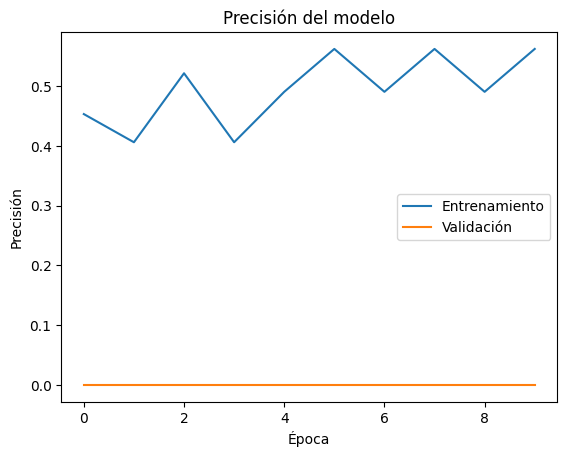

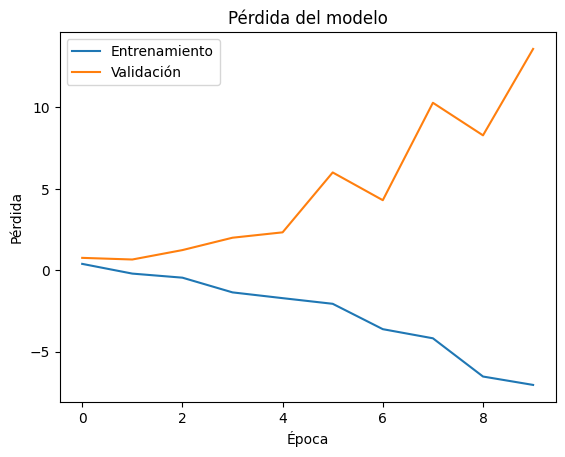

In [25]:
# Precisión

### evaluamos el modelo
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.show()

# Pérdida
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend()
plt.show()


In [26]:
### Guardamos el modelo


model.save('stop_sign_classifier.h5')


In [29]:


### Desplegar el modelo en aplicacion web

!pip install streamlit
!pip install pyngrok


import streamlit as st
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image, ImageOps

st.title('Clasificador de Señales de Stop')

# Remove the deprecated line
# st.set_option('deprecation.showfileUploaderEncoding', False)

@st.cache(allow_output_mutation=True)
def load_my_model():
    model = load_model('stop_sign_classifier.h5')
    return model

model = load_my_model()

st.write("""
         ## Sube una imagen para clasificarla
         """)

uploaded_file = st.file_uploader("Elige una imagen...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Cargar la imagen
    img = Image.open(uploaded_file)
    img_resized = img.resize((64, 64))
    img_array = image.img_to_array(img_resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Realizar la predicción
    prediction = model.predict(img_array)
    if prediction[0] > 0.5:
        st.write("**No es una señal de Stop**")
    else:
        st.write("**¡Es una señal de Stop!**")

    st.image(img, caption='Imagen subida', use_column_width=True)

2024-12-04 21:44:00.398 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-04 21:44:00.456 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-12-04 21:44:00.457 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-04 21:44:00.460 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-04 21:44:00.462 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-04 21:44:00.464 
`st.cache` is deprecated and will be removed soon. Please use one of Streamlit's new
caching commands, `st.cache_data` or `st.cache_resource`. More information
[in our docs](https://docs.streamlit.io/develop/concepts/architecture/caching).

**Note**: The behavior of `st.cac

In [32]:
import streamlit
import tensorflow
import PIL

print("Streamlit version:", streamlit.__version__)
print("TensorFlow version:", tensorflow.__version__)
print("Pillow version:", PIL.__version__)

Streamlit version: 1.40.2
TensorFlow version: 2.17.1
Pillow version: 11.0.0
